# EE219 Project 4: Regression Analysis

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   


### Part 1) Load the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/network_backup_dataset.csv', header=0)
df_index = ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', \
            'Work-Flow-ID', 'File Name', 'Size of Backup (GB)', \
            'Backup Time (hour)', 'day number']
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, \
           'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

#### create day number column

In [3]:
day_number = []
for weeknum, dayofweek in np.array(df[df_index[:2]]):
    day_number.append( (weeknum-1)*7 + map_day[dayofweek] )
df['day number'] = day_number

**(a) For a twenty-day period (X-axis unit is day number) plot the backup sizes for
all workflows (color coded on the Y-axis)**

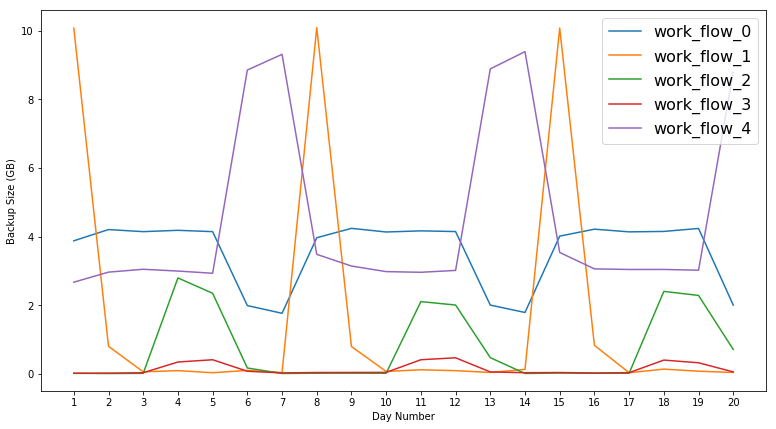

In [4]:
df_part1a = df.loc[ df['day number'] <= 20 ]
workflowlist = np.unique(df_part1a['Work-Flow-ID'])

plt.figure( figsize=(13, 7) )
for i in range(len(workflowlist)):
    temp = df_part1a.loc[ df_part1a['Work-Flow-ID'] == workflowlist[i] ]
    tempbackup = []
    for j in range(1,21):
        tempbackup.append( \
            sum( (temp.loc[temp['day number']==j])['Size of Backup (GB)']) )
    plt.plot(range(1,21), tempbackup, label=workflowlist[i])

plt.legend(loc='upper right', prop={'size': 16})
plt.ylabel('Backup Size (GB)')
plt.xlabel('Day Number')
plt.xticks(range(1,21))
plt.show()

**(b) Do the same plot for the first 105-day period.**

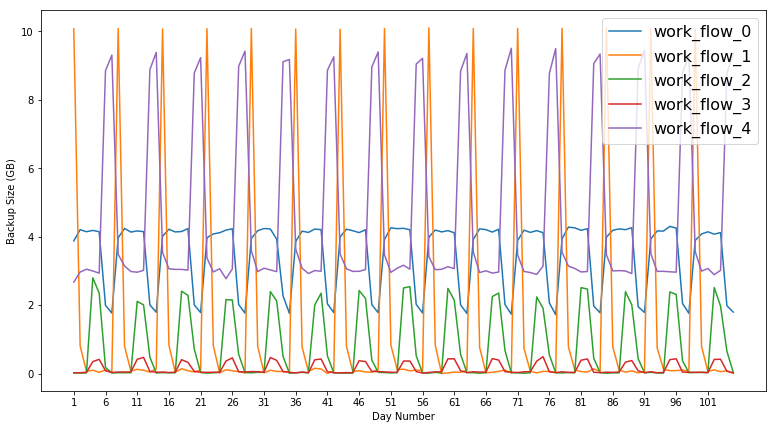

In [5]:
df_part1b = df.loc[ df['day number'] <= 105 ]
workflowlist = np.unique(df_part1b['Work-Flow-ID'])

plt.figure( figsize=(13, 7) )
for i in range(len(workflowlist)):
    temp = df_part1b.loc[ df_part1b['Work-Flow-ID'] == workflowlist[i] ]
    tempbackup = []
    for j in range(1,106):
        tempbackup.append( \
            sum( (temp.loc[temp['day number']==j])['Size of Backup (GB)']) )
    plt.plot(range(1,106), tempbackup, label=workflowlist[i])

plt.legend(loc='upper right', prop={'size': 16})
plt.ylabel('Backup Size (GB)')
plt.xlabel('Day Number')
plt.xticks(range(1,106,5))
plt.show()


### Part 2) Predict the backup size of a file given the other attributes.

#### a) Fit a linear regression model.

In [6]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [7]:
df.tail(3)

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour),day number
18585,15,Sunday,21,work_flow_4,File_26,0.198572,2,105
18586,15,Sunday,21,work_flow_4,File_25,0.199570,2,105
18587,15,Sunday,21,work_flow_4,File_24,0.201201,2,105


First convert each categorical feature into one dimensional numerical values
using scalar encoding.

In [8]:
week_number = df[df_index[0]].tolist()

day_of_week = []
for day in df[df_index[1]].tolist():
    day_of_week.append(map_day[day])
    
hour_of_day = df[df_index[2]].tolist()

workflowid = df[df_index[3]].tolist()
for i in range(len(workflowid)):
    workflowid[i] = int(workflowid[i].replace('work_flow_',''))

filename = df[df_index[4]].tolist()
for i in range(len(filename)):
    filename[i] = int(filename[i].replace('File_',''))

In [9]:
featurematrix = np.stack(\
        (week_number, day_of_week, hour_of_day, \
         workflowid, filename), axis=-1)

y = np.float64(df['Size of Backup (GB)'].tolist()) #'Size of Backup (GB)'

In [10]:
from sklearn.model_selection import cross_validate

def reportandplot(clt, X, y, verbose=True):
    cv_results = cross_validate(clt, X, y, \
                scoring='neg_mean_squared_error', cv=10, return_train_score=True)

    train_mse = np.mean(-cv_results['train_score'])
    test_mse = np.mean(-cv_results['test_score'])
    ave_train_rmse = np.sqrt(train_mse)
    ave_test_rmse = np.sqrt(test_mse)
    
    
    if verbose:
        clt.fit(X, y)
        y_predict = clt.predict(X)

        plt.scatter(y, y_predict)
        plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw = 3)
        plt.xlabel('True values')
        plt.ylabel('Fitted values')
        plt.show()

        plt.scatter(y_predict, y-y_predict)
        plt.xlabel('Fitted values')
        plt.ylabel('Residual')
        plt.show()

        print("Train set average RMSE: ", ave_train_rmse)
        print("Test set average RMSE: ", ave_test_rmse)
    
    return [ave_train_rmse, ave_test_rmse]

#### i) Naive linear regression

In [11]:
basicregression = LinearRegression()

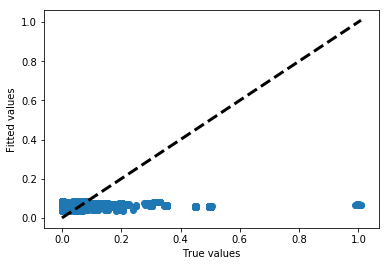

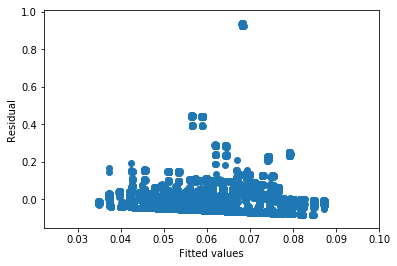

Train set average RMSE:  0.103585393643
Test set average RMSE:  0.103675847676


[0.10358539364277801, 0.10367584767599031]

In [12]:
reportandplot(basicregression, featurematrix, y)

#### ii) Data Preprocessing: with standardized feature data

In [13]:
stand = StandardScaler()
X_stand = stand.fit_transform(np.float64(featurematrix))

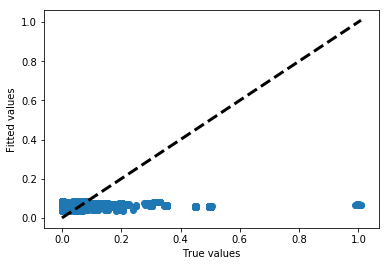

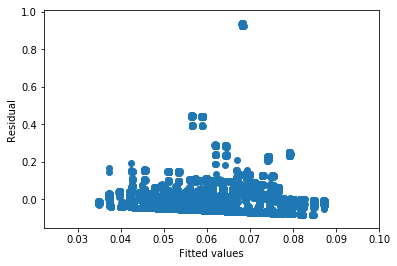

Train set average RMSE:  0.103585393643
Test set average RMSE:  0.103675847676


[0.10358539364277801, 0.10367584767599031]

In [14]:
reportandplot(basicregression, X_stand, y)

#### iii) Feature Selection: select three most important features

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression
best3_f = SelectKBest(f_regression, k=3)
X_best3_f = best3_f.fit_transform(featurematrix, y)
print("best 3 for f_regression: " + str(best3_f.get_support()))

best 3 for f_regression: [False  True  True  True False]


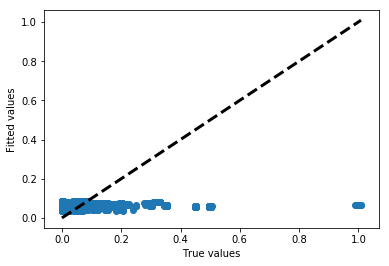

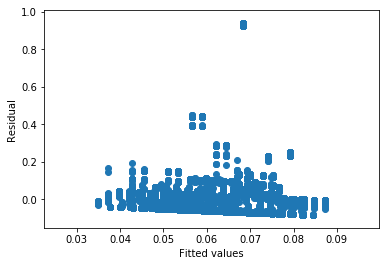

Train set average RMSE:  0.103585682142
Test set average RMSE:  0.103670661831


[0.10358568214188695, 0.10367066183103706]

In [16]:
reportandplot(basicregression, X_best3_f, y)

In [17]:
from sklearn.feature_selection import mutual_info_regression
best3_m = SelectKBest(mutual_info_regression, k=3)
X_best3_m = best3_m.fit_transform(np.float64(featurematrix), y)
print("best 3 for mutual_info_regression: " + str(best3_m.get_support()))

best 3 for mutual_info_regression: [False False  True  True  True]


In [18]:
print(X_best3_m[1:5,:])

[[  1.   2.  12.]
 [  1.   2.  13.]
 [  1.   2.  14.]
 [  1.   2.  16.]]


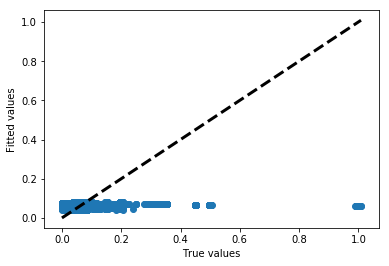

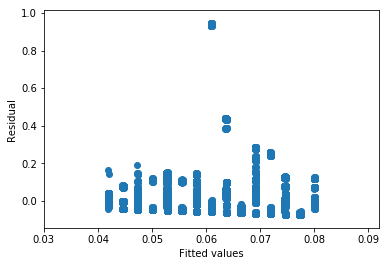

Train set average RMSE:  0.103694528194
Test set average RMSE:  0.103772293071


[0.10369452819355413, 0.10377229307066824]

In [19]:
reportandplot(basicregression, X_best3_m, y)

#### iv) Feature Encoding:

In [20]:
from sklearn.preprocessing import OneHotEncoder
import itertools
tftable = list(itertools.product([False, True], repeat=5))

for idx, comb in enumerate(tftable):
    print("Combination ", idx, ":\t ", comb)

Combination  0 :	  (False, False, False, False, False)
Combination  1 :	  (False, False, False, False, True)
Combination  2 :	  (False, False, False, True, False)
Combination  3 :	  (False, False, False, True, True)
Combination  4 :	  (False, False, True, False, False)
Combination  5 :	  (False, False, True, False, True)
Combination  6 :	  (False, False, True, True, False)
Combination  7 :	  (False, False, True, True, True)
Combination  8 :	  (False, True, False, False, False)
Combination  9 :	  (False, True, False, False, True)
Combination  10 :	  (False, True, False, True, False)
Combination  11 :	  (False, True, False, True, True)
Combination  12 :	  (False, True, True, False, False)
Combination  13 :	  (False, True, True, False, True)
Combination  14 :	  (False, True, True, True, False)
Combination  15 :	  (False, True, True, True, True)
Combination  16 :	  (True, False, False, False, False)
Combination  17 :	  (True, False, False, False, True)
Combination  18 :	  (True, False, Fal

In [21]:
def findbestcomb(clf, X, y, verbose=True):
    train_rmse_lst = []
    test_rmse_lst = []

    tftable = list(itertools.product([False, True], repeat=5))
    for comb in tftable:
        enc = OneHotEncoder(categorical_features=comb, sparse=False)
        X_enc = enc.fit_transform(np.float64(X))
        cv_results = cross_validate(clf, X_enc, y, \
                scoring='neg_mean_squared_error', cv=10, return_train_score=True)
        train_rmse = np.mean(np.sqrt(-cv_results['train_score']))
        test_rmse = np.mean(np.sqrt(-cv_results['test_score']))
        train_rmse_lst.append(train_rmse)
        test_rmse_lst.append(test_rmse)

    best_comb_idx = np.argmin(test_rmse_lst)
    if verbose:
        print("Best combination is: ", tftable[best_comb_idx])
        print([df_index[i] for i, x in enumerate(tftable[best_comb_idx]) if x])
        print("Train RMSE, Test RMSE: ", train_rmse_lst[best_comb_idx], test_rmse_lst[best_comb_idx])
    
    return (tftable[best_comb_idx], best_comb_idx, train_rmse_lst, test_rmse_lst)

In [22]:
(_, best_comb_idx, train_rmse_lst, test_rmse_lst) = findbestcomb(basicregression, featurematrix, y)

Best combination is:  (False, True, True, True, True)
['Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']
Train RMSE, Test RMSE:  0.0883366063535 0.0883706240276


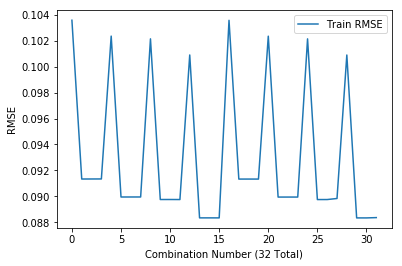

In [23]:
plt.plot(train_rmse_lst, label="Train RMSE")
plt.xlabel('Combination Number (32 Total)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

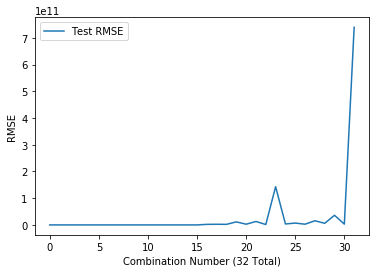

In [24]:
plt.plot(test_rmse_lst, label="Test RMSE")
plt.xlabel('Combination Number (32 Total)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#### v) Controlling ill-conditioning and over-fiting:

##### With Ridge Regularizer

In [25]:
from sklearn.linear_model import Ridge

min_rmse_r = 1
min_a_r = 0
min_comb_r = tftable[0]
for a in [3**num for num in range(-7,8)]:
    ridgeregression = Ridge(alpha=a)
    (bc, bci, trn, tst) = findbestcomb(ridgeregression, featurematrix, y, verbose=False)
    if tst[bci] < min_rmse_r:
        min_a_r = a
        min_comb_r = bc
        min_rmse_r = tst[bci]
        
print("With ridge regression, best alpha \nand best combination is: ", (min_a_r, min_comb_r))
print([df_index[i] for i, x in enumerate(min_comb_r) if x])
print("Test RMSE: ", min_rmse_r)

With ridge regression, best alpha 
and best combination is:  (3, (False, True, True, True, False))
['Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID']
Test RMSE:  0.0883677426258


##### With Lasso Regularizer

In [26]:
from sklearn.linear_model import Lasso

min_rmse_l = 1
min_a_l = 0
min_comb_l = tftable[0]
for a in [3**num for num in range(-7,8)]:
    lassoregression = Lasso(alpha=a)
    (bc, bci, trn, tst) = findbestcomb(lassoregression, featurematrix, y, verbose=False)
    if tst[bci] < min_rmse_l:
        min_a_l = a
        min_comb_l = bc
        min_rmse_l = tst[bci]
        
print("With ridge regression, best alpha \nand best combination is: ", (min_a_l, min_comb_l))
print([df_index[i] for i, x in enumerate(min_comb_l) if x])
print("Test RMSE: ", min_rmse_l)

With ridge regression, best alpha 
and best combination is:  (0.0004572473708276177, (True, True, True, True, True))
['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']
Test RMSE:  0.0884676783956


##### coefficients of best unregularized model

In [27]:
enc = OneHotEncoder(categorical_features=tftable[best_comb_idx], sparse=False)
X_enc = enc.fit_transform(np.float64(featurematrix))
basicregression.fit(X_enc, y)
print(basicregression.coef_)

[  1.96145460e+10   1.96145460e+10   1.96145460e+10   1.96145460e+10
   1.96145460e+10   1.96145460e+10   1.96145460e+10  -2.89569745e+10
  -2.89569745e+10  -2.89569745e+10  -2.89569745e+10  -2.89569745e+10
  -2.89569745e+10   1.65056477e+10  -4.39256988e+10  -1.67303354e+10
  -2.26495354e+09  -5.20965060e+10  -2.98779213e+10  -2.98779213e+10
  -2.98779213e+10  -2.98779213e+10  -2.98779213e+10  -2.98779213e+10
   3.05534252e+10   3.05534252e+10   3.05534252e+10   3.05534252e+10
   3.05534252e+10   3.05534252e+10   3.35806181e+09   3.35806181e+09
   3.35806181e+09   3.35806181e+09   3.35806181e+09   3.35806181e+09
  -1.11073201e+10  -1.11073201e+10  -1.11073201e+10  -1.11073201e+10
  -1.11073201e+10  -1.11073201e+10   3.87242323e+10   3.87242323e+10
   3.87242323e+10   3.87242323e+10   3.87242323e+10   3.87242323e+10
   8.94069672e-06]


##### coefficients of best regularized model (Ridge)

In [28]:
enc = OneHotEncoder(categorical_features=min_comb_r, sparse=False)
X_enc = enc.fit_transform(np.float64(featurematrix))
ridgeregression = Ridge(alpha=min_a_r)
ridgeregression.fit(X_enc, y)
print(ridgeregression.coef_)

[  3.92669163e-02  -1.28487144e-02  -2.02445927e-02  -5.24244158e-03
  -5.69974195e-03   3.27354301e-03   1.49503134e-03  -2.01859243e-02
  -2.10402115e-02   7.78402332e-03   3.34228557e-02  -1.98663507e-03
   2.00589195e-03   3.88382162e-02  -1.37318537e-02  -4.01695350e-02
  -5.71824730e-02   7.22456456e-02   1.12166970e-05   5.37811040e-05]


##### coefficients of best regularized model (Lasso)

In [29]:
enc = OneHotEncoder(categorical_features=min_comb_l, sparse=False)
X_enc = enc.fit_transform(np.float64(featurematrix))
lassoregression = Lasso(alpha=min_a_l)
lassoregression.fit(X_enc, y)
print(lassoregression.coef_)

[-0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
 -0.          0.04001671 -0.00550534 -0.01322969 -0.         -0.
  0.00401878  0.00223829 -0.01755974 -0.01823346  0.00504044  0.0307037  -0.
  0.          0.0499828  -0.         -0.02400039 -0.04072367  0.08463377
  0.          0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
  0.          0.        ]


### Part b) Use a random forest regression model for this same task.

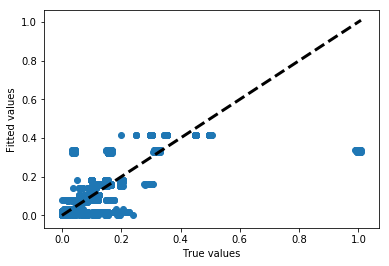

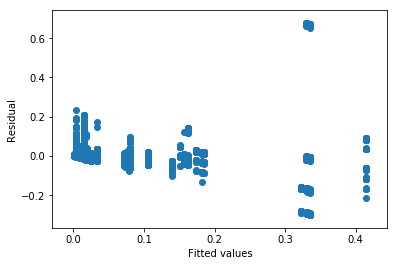

Train set average RMSE:  0.0602893787846
Test set average RMSE:  0.0605035996763
Out of bag error:  0.34240045465


In [30]:
from sklearn.ensemble import RandomForestRegressor 

randomforest = RandomForestRegressor(n_estimators=20, \
                                     max_features=5, max_depth=4, \
                                     bootstrap=True, oob_score=True, n_jobs=1)

[a,b]=reportandplot(randomforest, featurematrix, y)
print("Out of bag error: ", 1-randomforest.oob_score_)

In [31]:
print(a,b)
print(randomforest.feature_importances_)

0.0602893787846 0.0605035996763
[  5.11824899e-06   2.69797281e-01   1.49434650e-01   1.53752433e-01
   4.27010518e-01]


In [32]:
randomforest.fit(featurematrix, y)
y_pred = randomforest.predict(featurematrix)
sdf = mean_squared_error(y_pred, y)
print(sdf)

0.00371214431838
